In [23]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from detectdd.auth_bigquery import BigQueryClient
from detectdd.serializer import Serializer

serializer = Serializer()
cohort_before_icd_filter = serializer.read_total_drug_interactions()
print(len(cohort_before_icd_filter))
cohort_before_icd_filter.head(100)

Loaded cohort from ..\out\total-drug-interactions.out
49552


,subject_id,hadm_id,stay_id,drug_a_item_id,drug_b_item_id,dose_b_time,event_count,admin_count
0,10245250,26727785,32875883,225798,225893,2186-05-05 07:50:00,5,1.0
1,10404109,29867820,31722715,225798,225893,2146-12-28 20:00:00,4,1.0
2,10404109,29867820,31722715,225798,225893,2146-12-29 08:06:00,4,3.0
3,10404109,29867820,31722715,225798,225893,2146-12-31 07:56:00,4,10.0
6,10990398,27541056,32331290,225798,225893,2175-12-13 11:00:00,9,7.0
...,...,...,...,...,...,...,...,...
104,14798663,27815009,32942858,225798,225893,2113-10-25 02:39:00,3,14.0
105,14798663,27815009,32942858,225798,225893,2113-10-25 13:36:00,3,11.0
106,15115424,29747913,38758694,225798,225892,2134-10-06 23:11:00,2,3.0
107,15270301,27738686,37568338,225798,225893,2160-02-29 17:15:00,82,1.0


In [24]:
from detectdd.config import icd_data_file
# read ICD code data
icd_codes_raw = pd.read_csv(icd_data_file, encoding='ISO-8859-1')

category_prefixes = ('A', 'B', 'C', 'D')
#category_prefixes = ('A','B', 'C')

def filter_icd_codes(to_filter):
    # The data contains filters with the following meaning.
    #A.1	Induced by medication
    #A.2	Induced by medication or other causes
    #B.1	Poisoning by medication
    #B.2	Poisoning by or harmful use of medication or other causes
    #C	ADE very likely
    #D	ADE likely
    #E	ADE possible
    #U	ADE unlikely
    #V	Induced by vaccine (added)
    
    # simple filter, only accept at A - D
    

    return to_filter.loc[to_filter.iloc[:, 2].str.startswith(category_prefixes, na=False)]
    # TODO - exclude codes where it is unlikely to be drug drug interaction, i.e. T40
    
icd_codes_filtered = filter_icd_codes(icd_codes_raw)
icd_codes_filtered

,Code,Meaning,Consensus Likelihood Rating
0,D52.1,Drug-induced folate deficiency anaemia,A1
1,D59.0,Drug-induced autoimmune haemolytic anaemia,A1
2,D59.2,Drug-induced nonautoimmune haemolytic anaemia,A1
3,D61.1,Drug-induced aplastic anaemia due to chemotherapy,A1
4,D68.3,Hemorrhagic disorder due to circulating antico...,A1
...,...,...,...
435,N19,Unspecified renal failure,D
436,O26.6,"Liver disorders in pregnancy, childbirth and t...",D
437,O74.6,Other complications of spinal and epidural ana...,D
438,T88.5,Other complications of anaesthesia,D


In [25]:
hosp = "physionet-data.mimiciv_hosp"
def get_hadm_id_with_matching_icd_code(icd_codes_filtered=icd_codes_filtered, hadm_ids = [24233473]):
    icd_in_values = ', '.join(["'" + str(x).replace('.','') + "'" for x in icd_codes_filtered['Code'].tolist()])

    likes = []
    codes = icd_codes_filtered['Code']
    
    cleaned_codes = []
    
    for x in codes:
        x = x.replace('.','')
        if len(x) < 5:
            cleaned_codes.append(x + 'X')
    
    cleaned_codes += ["E93", "E94", "E85", "E86"] #ICD 9 therapeutic use and poising prefix, maps to B and A categories
  
    for x in cleaned_codes:
        likes.append(f"d_icd.icd_code LIKE '{x}%'")
    like_clause = "\n OR ".join(likes)
    
    sql = f"""SELECT diag.hadm_id, 
        diag.subject_id, 
          
        COUNT(distinct d_icd.icd_code) AS num_icd_codes,
        
        ARRAY_AGG(d_icd.icd_code) AS icd_code, 
        ARRAY_AGG(DISTINCT d_icd.icd_version) AS icd_versions,
        STRING_AGG(d_icd.long_title) AS icd_titles
        FROM `{hosp}.diagnoses_icd` AS diag
        INNER JOIN `{hosp}.d_icd_diagnoses` AS d_icd
            ON diag.icd_code = d_icd.icd_code
            AND diag.icd_version= d_icd.icd_version
            AND ( d_icd.icd_code IN ({icd_in_values}) OR 
                {like_clause})
        WHERE diag.hadm_id IN ({','.join([str(x) for x in hadm_ids])})
        GROUP BY diag.hadm_id, diag.subject_id
        ORDER BY diag.subject_id"""

    mimic_job = BigQueryClient.auth().query(sql)
    return mimic_job.to_dataframe()

hadm_with_icd_codes = get_hadm_id_with_matching_icd_code(hadm_ids = cohort_before_icd_filter["hadm_id"].drop_duplicates())
print(f"Found {len(hadm_with_icd_codes)} unique hamds codes with icd codes in categories: {category_prefixes}")
hadm_with_icd_codes.head(100)

<google.oauth2.credentials.Credentials object at 0x00000278A8547040> mimic-iv-desktop
Found 3179 unique codes with icd stays in categories: ('A', 'B', 'C', 'D')


,hadm_id,subject_id,num_icd_codes,icd_code,icd_versions,icd_titles
0,26184834,10001884,1,[D696],[10],"Thrombocytopenia, unspecified"
1,23559586,10003400,3,"[D696, N179, D62]",[10],"Thrombocytopenia, unspecified,Acute kidney fai..."
2,27411876,10004733,1,[E9383],[9],Intravenous anesthetics causing adverse effect...
3,20364112,10005866,3,"[K265, D62, K255]",[10],Chronic or unspecified duodenal ulcer with per...
4,22987108,10007818,2,"[N179, D62]",[10],"Acute kidney failure, unspecified,Acute posthe..."
...,...,...,...,...,...,...
95,27950271,10297774,2,"[N170, T447X5A]",[10],"Acute kidney failure with tubular necrosis,Adv..."
96,22548200,10302157,2,"[N179, D62]",[10],"Acute kidney failure, unspecified,Acute posthe..."
97,25734192,10306412,1,[E9331],[9],Antineoplastic and immunosuppressive drugs cau...
98,26219083,10307557,1,[E9309],[9],Unspecified antibiotic causing adverse effects...


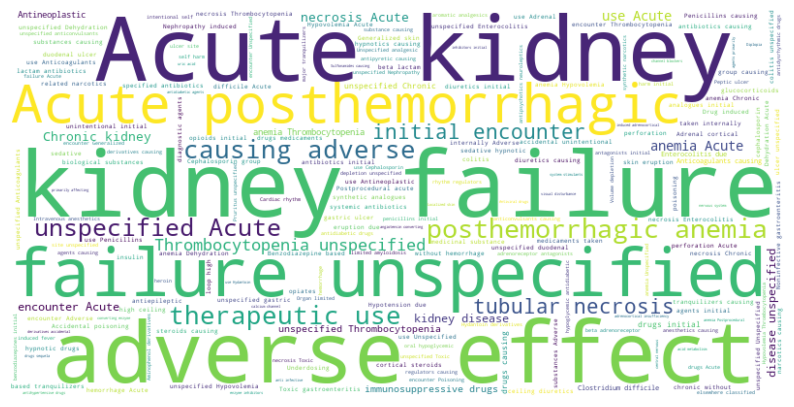

In [26]:
def create_word_cloud_from_column(df, column):
        text = ",".join(df[column])
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
        
        # Display the word cloud using matplotlib
        plt.figure(figsize=(10, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.show()
        
create_word_cloud_from_column(hadm_with_icd_codes, "icd_titles")

In [27]:
drug_interactions_joined_with_icd = pd.merge(left=cohort_before_icd_filter, right=hadm_with_icd_codes, how='left', on=['hadm_id', 'subject_id'], validate='many_to_one')

print(len(drug_interactions_joined_with_icd))
drug_interactions_joined_with_icd.head(1000)




49552


,subject_id,hadm_id,stay_id,drug_a_item_id,drug_b_item_id,dose_b_time,event_count,admin_count,num_icd_codes,icd_code,icd_versions,icd_titles
0,10245250,26727785,32875883,225798,225893,2186-05-05 07:50:00,5,1.0,1,[D62],[10],Acute posthemorrhagic anemia
1,10404109,29867820,31722715,225798,225893,2146-12-28 20:00:00,4,1.0,<NA>,NaN,NaN,NaN
2,10404109,29867820,31722715,225798,225893,2146-12-29 08:06:00,4,3.0,<NA>,NaN,NaN,NaN
3,10404109,29867820,31722715,225798,225893,2146-12-31 07:56:00,4,10.0,<NA>,NaN,NaN,NaN
4,10990398,27541056,32331290,225798,225893,2175-12-13 11:00:00,9,7.0,1,[E9320],[9],Adrenal cortical steroids causing adverse effe...
...,...,...,...,...,...,...,...,...,...,...,...,...
995,10995312,20254002,36710527,225798,225893,2161-08-28 07:47:00,13,1.0,<NA>,NaN,NaN,NaN
996,11247436,26290780,37270178,225798,225893,2164-02-03 12:30:00,10,4.0,2,"[E9309, E9347]",[9],Unspecified antibiotic causing adverse effects...
997,11247436,26290780,37270178,225798,225893,2164-02-02 20:09:00,10,5.0,2,"[E9309, E9347]",[9],Unspecified antibiotic causing adverse effects...
998,11247436,26290780,37270178,225798,225893,2164-02-01 20:00:00,10,4.0,2,"[E9309, E9347]",[9],Unspecified antibiotic causing adverse effects...


In [28]:
cohort_without_icd = drug_interactions_joined_with_icd[drug_interactions_joined_with_icd.num_icd_codes.isna()]
cohort_with_icd = drug_interactions_joined_with_icd[~drug_interactions_joined_with_icd.num_icd_codes.isna()]
print(f"Total {len(drug_interactions_joined_with_icd)} drug interactions ")
print(f"Found {len(cohort_with_icd)} drug interactions with icd codes")
print(f"Found {len(cohort_without_icd)} drug interactions without icd codes")

Total 49552 drug interactions 
Found 20625 drug interactions with icd codes
Found 28927 drug interactions without icd codes


In [29]:
## TODO remove truncation, use p95 or p99 instead, this is here to speed up development
print("Truncating cohort to 75th percentile (18)")
counts = cohort_with_icd['stay_id'].value_counts()
print(cohort_with_icd.describe())
print(counts.describe())
truncated_cohort = cohort_with_icd[cohort_with_icd['stay_id'].map(counts) <= 18]
print(truncated_cohort.describe())

counts = cohort_without_icd['stay_id'].value_counts()
truncated_cohort_without_icd = cohort_without_icd[cohort_without_icd['stay_id'].map(counts) <= 18]

serializer.write_cohort(truncated_cohort)

print(len(truncated_cohort_without_icd))
serializer.write_cohort_with_no_icd(truncated_cohort_without_icd)

Truncating cohort to 75th percentile (18)
            subject_id          hadm_id          stay_id  \
count          20625.0          20625.0          20625.0   
mean   14854990.803297  24942899.371879  35037236.122909   
min         10001884.0       20014219.0       30002654.0   
25%         12384056.0       22592769.0       32416354.0   
50%         14816494.0       24877019.0       35047635.0   
75%         17369878.0       27332538.0       37598381.0   
max         19995595.0       29996046.0       39999230.0   
std     2895277.928755   2818256.945818   2954620.202722   

                      dose_b_time  event_count   admin_count  num_icd_codes  
count                       20625      20625.0  20625.000000        20625.0  
mean   2153-12-07 07:06:53.314909    10.732073      4.026230       1.940945  
min           2110-03-01 01:04:00          0.0      1.000000            1.0  
25%           2133-03-18 14:30:00          2.0      1.000000            1.0  
50%           2154-07-28 20

In [30]:
cohort_with_icd.groupby('stay_id').count().describe(percentiles=[ .25, .5, .75, 0.9, 0.95, 0.975, .99])

,subject_id,hadm_id,drug_a_item_id,drug_b_item_id,dose_b_time,event_count,admin_count,num_icd_codes,icd_code,icd_versions,icd_titles
count,3352.000000,3352.000000,3352.000000,3352.000000,3352.000000,3352.000000,3352.000000,3352.000000,3352.000000,3352.000000,3352.000000
mean,6.153043,6.153043,6.153043,6.153043,6.153043,6.153043,6.153043,6.153043,6.153043,6.153043,6.153043
std,10.690939,10.690939,10.690939,10.690939,10.690939,10.690939,10.690939,10.690939,10.690939,10.690939,10.690939
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
75%,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000
90%,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000
95%,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000
97.5%,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000


In [31]:
cohort_without_icd.groupby('stay_id').count().describe(percentiles=[ .25, .5, .75, 0.9, 0.95, 0.975, .99])

,subject_id,hadm_id,drug_a_item_id,drug_b_item_id,dose_b_time,event_count,admin_count,num_icd_codes,icd_code,icd_versions,icd_titles
count,4501.000000,4501.000000,4501.000000,4501.000000,4501.000000,4501.000000,4501.000000,4501.0,4501.0,4501.0,4501.0
mean,6.426794,6.426794,6.426794,6.426794,6.426794,6.426794,6.426794,0.0,0.0,0.0,0.0
std,10.132490,10.132490,10.132490,10.132490,10.132490,10.132490,10.132490,0.0,0.0,0.0,0.0
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,0.0
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,0.0
50%,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,0.0,0.0,0.0,0.0
75%,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,0.0,0.0,0.0,0.0
90%,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,0.0,0.0,0.0,0.0
95%,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,0.0,0.0,0.0,0.0
97.5%,31.500000,31.500000,31.500000,31.500000,31.500000,31.500000,31.500000,0.0,0.0,0.0,0.0


In [32]:
print(len(truncated_cohort))
truncated_cohort.groupby('stay_id').count().describe(percentiles=[ .25, .5, .75, 0.9, 0.95, 0.975, .99])

13196


,subject_id,hadm_id,drug_a_item_id,drug_b_item_id,dose_b_time,event_count,admin_count,num_icd_codes,icd_code,icd_versions,icd_titles
count,3140.000000,3140.000000,3140.000000,3140.000000,3140.000000,3140.000000,3140.000000,3140.000000,3140.000000,3140.000000,3140.000000
mean,4.202548,4.202548,4.202548,4.202548,4.202548,4.202548,4.202548,4.202548,4.202548,4.202548,4.202548
std,3.988322,3.988322,3.988322,3.988322,3.988322,3.988322,3.988322,3.988322,3.988322,3.988322,3.988322
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
75%,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000
90%,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
95%,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000
97.5%,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
